In [0]:
keys = spark.read.csv('/FileStore/tables/dev_user_databricks_accessKeys.csv', inferSchema=True, header=True)
Access_Id = keys.first()[0]
Secret_Id = keys.first()[1]

access_key = Access_Id
secret_key = Secret_Id
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)

aws_region = "us-east-1"
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# pip install fsspec
# %pip install s3fs

In [0]:
df = spark.read.parquet('s3a://project-bucket-17/Output_uk_data/')
pdf = df.toPandas()
print(pdf.shape)
pdf.head()

(354345, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850,United Kingdom,20.34


In [0]:
pdf['InvoiceDate'] = pd.to_datetime(pdf['InvoiceDate'])
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354345 entries, 0 to 354344
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  int32         
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int32         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  object        
 7   Country      354345 non-null  object        
 8   TotalAmount  354345 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), object(4)
memory usage: 21.6+ MB


In [0]:
pdf[pdf['InvoiceDate'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount


In [0]:
import datetime as dt

# Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011, 12, 10)

# Create RFM Modelling scores for each customer
RFMScores = pdf.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (Latest_Date - x.max()).days,
    'InvoiceNo': lambda x: len(x),
    'TotalAmount': lambda x: x.sum()
})

# Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

# Rename column names to Recency, Frequency, and Monetary
RFMScores.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

RFMScores.reset_index(inplace=True)
RFMScores.head()


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12747,2,103,4196.01
2,12748,0,4596,33719.73
3,12749,3,199,4090.88
4,12820,3,59,942.34


In [0]:
# Descriptive Statistics (Recency)
RFMScores.Recency.describe()

Out[8]: count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

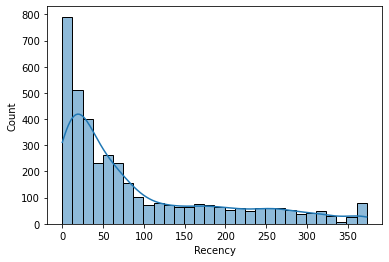

In [0]:
#Recency distribution plot

fig, ax = plt.subplots()
r = RFMScores['Recency']

# Plot the distribution using seaborn's histplot
sns.histplot(r, bins=30, kde=True, ax=ax)

# Set x-axis scale to linear
ax.set_xscale('linear')

# Set x-axis ticks to an interval of 50
plt.xticks(range(0, max(r)+1, 50))

# Show the plot
plt.show()

In [0]:
# Descriptive Statistics (Frequency)
RFMScores.Frequency.describe()

Out[10]: count    3921.000000
mean       90.371079
std       217.796155
min         1.000000
25%        17.000000
50%        41.000000
75%        99.000000
max      7847.000000
Name: Frequency, dtype: float64

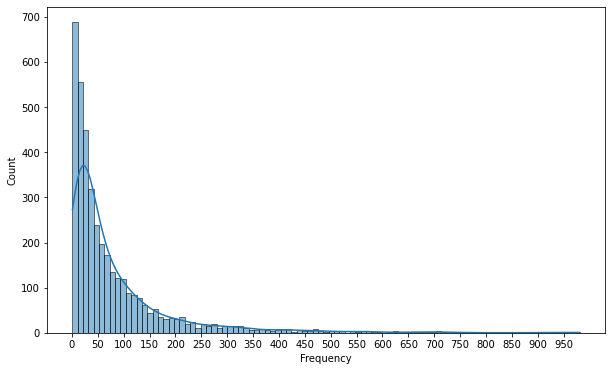

In [0]:
#Frequency distribution plot, taking observations which have frequency less than 1000

f = RFMScores.query('Frequency < 1000')['Frequency']

# Set figure size
plt.figure(figsize=(10, 6))

ax = sns.histplot(f, kde=True)
plt.xticks(range(0, 1000, 50))  # set x-axis tick marks to interval of 50
plt.show()

In [0]:
# Descriptive Statistics (Monetary)
RFMScores.Monetary.describe()

Out[12]: count      3921.000000
mean       1863.910113
std        7481.922217
min           0.000000
25%         300.040000
50%         651.820000
75%        1575.890000
max      259657.300000
Name: Monetary, dtype: float64

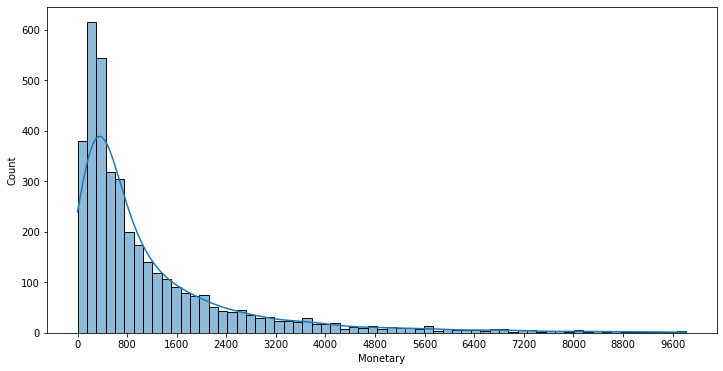

In [0]:
# Monateray distribution plot, taking observations which have monetary value less than 10000

m = RFMScores.query('Monetary < 10000')['Monetary']

# Set figure size
plt.figure(figsize=(12, 6))

ax = sns.histplot(m, kde=True)
plt.xticks(range(0, 10000, 800))  # set x-axis tick marks to interval of 50
plt.show()

In [0]:
# Calculate segments
segments = RFMScores[['Recency', 'Frequency', 'Monetary']].quantile(q=[0.2, 0.4, 0.6, 0.8])
segments = segments.to_dict()

In [0]:
# Functions to create R, F, and M segments
def RScoring(x, p, d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FnMScoring(x, p, d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [0]:
# Create R, F, and M segments
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency', segments))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency', segments))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary', segments))

RFMScores.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346,325,1,77183.60,1,1,5
1,12747,2,103,4196.01,5,4,5
2,12748,0,4596,33719.73,5,5,5
3,12749,3,199,4090.88,5,5,5
4,12820,3,59,942.34,5,4,4


In [0]:
# Combine R, F, and M segments
RFMScores['RFMGroup'] = RFMScores['R'].map(str) + RFMScores['F'].map(str) + RFMScores['M'].map(str)

# Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)

RFMScores.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
0,12346,325,1,77183.60,1,1,5,115,7
1,12747,2,103,4196.01,5,4,5,545,14
2,12748,0,4596,33719.73,5,5,5,555,15
3,12749,3,199,4090.88,5,5,5,555,15
4,12820,3,59,942.34,5,4,4,544,13


In [0]:
# Assign Loyalty Level to each customer

Loyalty_Level = ['Basic', 'Silver', 'Gold', 'Platinum', 'Diamond']
Score_cuts = pd.qcut(RFMScores.RFMScore, q=5, labels=Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values

RFMScores.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346,325,1,77183.60,1,1,5,115,7,Silver
1,12747,2,103,4196.01,5,4,5,545,14,Diamond
2,12748,0,4596,33719.73,5,5,5,555,15,Diamond
3,12749,3,199,4090.88,5,5,5,555,15,Diamond
4,12820,3,59,942.34,5,4,4,544,13,Platinum


In [0]:
# Validate the data for RFMGroup = 111
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
2586,16427,263,9,241.06,1,1,1,111,3,Basic
2823,16756,214,13,239.40,1,1,1,111,3,Basic
3046,17060,266,5,234.24,1,1,1,111,3,Basic
689,13786,367,7,230.40,1,1,1,111,3,Basic
635,13712,246,10,228.84,1,1,1,111,3,Basic
180,13070,192,9,228.80,1,1,1,111,3,Basic
3146,17212,253,4,226.85,1,1,1,111,3,Basic
2697,16587,232,13,225.15,1,1,1,111,3,Basic
2619,16471,274,13,223.95,1,1,1,111,3,Basic
2077,15724,201,11,218.25,1,1,1,111,3,Basic


In [0]:
# Validate the data for RFMGroup = 555
RFMScores[RFMScores['RFMGroup']=='555'].sort_values('Monetary', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
3784,18102,0,431,259657.30,5,5,5,555,15,Diamond
3315,17450,8,337,194550.79,5,5,5,555,15,Diamond
3357,17511,2,963,91062.38,5,5,5,555,15,Diamond
2767,16684,4,277,66653.56,5,5,5,555,15,Diamond
903,14096,4,5111,65164.79,5,5,5,555,15,Diamond
621,13694,3,568,65039.62,5,5,5,555,15,Diamond
1772,15311,0,2379,60767.90,5,5,5,555,15,Diamond
191,13089,2,1818,58825.83,5,5,5,555,15,Diamond
2110,15769,7,130,56252.72,5,5,5,555,15,Diamond
1580,15061,3,403,54534.14,5,5,5,555,15,Diamond


In [0]:
RFMScores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   CustomerID         3921 non-null   object  
 1   Recency            3921 non-null   int64   
 2   Frequency          3921 non-null   int64   
 3   Monetary           3921 non-null   float64 
 4   R                  3921 non-null   int64   
 5   F                  3921 non-null   int64   
 6   M                  3921 non-null   int64   
 7   RFMGroup           3921 non-null   object  
 8   RFMScore           3921 non-null   int64   
 9   RFM_Loyalty_Level  3921 non-null   category
dtypes: category(1), float64(1), int64(6), object(2)
memory usage: 279.9+ KB


In [0]:
# Converting Pandas DF to PySpark DF
RFMScores_spark = spark.createDataFrame(RFMScores)

RFMScores_spark = RFMScores_spark.repartition(1)

In [0]:
# Exporting the file into s3 bucket as a csv format
# RFMScores_spark.write.mode('overwrite').option("header", "true").csv('s3://project-bucket-17/Output_RFM_Modelling')